In [ ]:
import pandas as pd

df_train = pd.read_csv('/content/drive/MyDrive/STSB_MT_TURKISH/stsb_mt_turkish_train')
df_test = pd.read_csv('/content/drive/MyDrive/STSB_MT_TURKISH/stsb_mt_turkish_test')
df_val = pd.read_csv('/content/drive/MyDrive/STSB_MT_TURKISH/stsb_mt_turkish_validation')

In [ ]:
import pandas as pd
import re

def temizle_noktalama(df, kolon_adi):
    """
    Belirtilen DataFrame sütunundaki metinlerden tırnak işaretleri, @ ve # karakterlerini temizler.

    Parametreler:
    df (pd.DataFrame): İşlem yapılacak veri seti.
    kolon_adi (str): Temizleme işlemi yapılacak sütunun adı.

    Dönüş:
    pd.DataFrame: Güncellenmiş DataFrame.
    """
    # Tırnak işaretleri ve istenmeyen semboller
    regex_tirnaklar = r"[\"\'“”‘’`´@#]"

    # Temizleme işlemi
    df[kolon_adi] = df[kolon_adi].astype(str).apply(lambda x: re.sub(regex_tirnaklar, '', x))

    return df

df_train = temizle_noktalama(df_train, 'sentence1')
df_train = temizle_noktalama(df_train, 'sentence2')
df_test = temizle_noktalama(df_test, 'sentence1')
df_test = temizle_noktalama(df_test, 'sentence2')
df_val = temizle_noktalama(df_val, 'sentence1')
df_val = temizle_noktalama(df_val, 'sentence2')

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_name = "xlm-roberta-base"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=1,  # Regresyon için tek çıktı
    problem_type="regression"
)


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
%%capture
!pip install datasets

In [ ]:
from datasets import Dataset

# Yeni bölünmüş veri çerçevelerini Hugging Face Dataset formatına dönüştür
train_dataset = Dataset.from_pandas(df_train.reset_index(drop=True))
test_dataset = Dataset.from_pandas(df_test.reset_index(drop=True))
val_dataset = Dataset.from_pandas(df_val.reset_index(drop=True))

In [ ]:
def preprocess(examples):
    # sentence1
    enc_a = tokenizer(
        examples["sentence1"],
        truncation=True,
        padding="max_length",
        max_length=90
    )
    # sentence2
    enc_b = tokenizer(
        examples["sentence2"],
        truncation=True,
        padding="max_length",
        max_length=90
    )
    return {
        "input_ids_a": enc_a["input_ids"],
        "attention_mask_a": enc_a["attention_mask"],
        "input_ids_b": enc_b["input_ids"],
        "attention_mask_b": enc_b["attention_mask"],
        "labels": examples["score"]
    }

# ✅ Yalnızca iki veri setine uygulanıyor
train_dataset = train_dataset.map(preprocess, batched=True)
test_dataset = test_dataset.map(preprocess, batched=True)
val_dataset = val_dataset.map(preprocess, batched=True)

# ✅ Formatlama
train_dataset.set_format(
    type="torch",
    columns=["input_ids_a", "attention_mask_a", "input_ids_b", "attention_mask_b", "labels"]
)
test_dataset.set_format(
    type="torch",
    columns=["input_ids_a", "attention_mask_a", "input_ids_b", "attention_mask_b", "labels"]
)

val_dataset.set_format(
    type="torch",
    columns=["input_ids_a", "attention_mask_a", "input_ids_b", "attention_mask_b", "labels"]
)

Map:   0%|          | 0/5749 [00:00<?, ? examples/s]

Map:   0%|          | 0/1379 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModel

# --------------------------------------------
# Hybrid SBERT + Cross-Attn + Multi-Head Attention + Attention Pooling
# --------------------------------------------

class AttentionPooling(nn.Module):
    def __init__(self, hidden_size):
        super(AttentionPooling, self).__init__()
        self.attn = nn.Linear(hidden_size, 1)

    def forward(self, x, mask):
        weights = self.attn(x).squeeze(-1)  # [B, T]
        weights = weights.masked_fill(mask == 0, -1e4)
        attn_weights = F.softmax(weights, dim=-1)
        pooled = torch.bmm(attn_weights.unsqueeze(1), x).squeeze(1)  # [B, H]
        return pooled

class HybridSTSModel(nn.Module):
    def __init__(self, model_name="xlm-roberta-base", hidden_size=768, fusion_size=1024, freeze_layers=6):
        super(HybridSTSModel, self).__init__()
        self.encoder = AutoModel.from_pretrained(model_name)

        # Gradual Unfreezing: encoder'ın alt katmanlarını dondur
        if hasattr(self.encoder, "encoder") and hasattr(self.encoder.encoder, "layer"):
            for i in range(freeze_layers):
                for param in self.encoder.encoder.layer[i].parameters():
                    param.requires_grad = False

        # Dikkat katmanları
        self.cross_attn = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=12, batch_first=True)
        self.mha = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=12, batch_first=True)
        self.attn_pool = AttentionPooling(hidden_size)

        # Regresyon başlığı
        self.proj = nn.Sequential(
            nn.Linear(hidden_size * 4, fusion_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.LayerNorm(fusion_size),
            nn.Linear(fusion_size, 1)
        )

        self.scale = nn.Parameter(torch.tensor(5.0))  # Çıkışı [0, 5] aralığına getirir

    def mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output[0]  # [B, T, H]
        mask_exp = attention_mask.unsqueeze(-1).expand(token_embeddings.size())
        summed = torch.sum(token_embeddings * mask_exp, dim=1)
        summed_mask = torch.clamp(mask_exp.sum(dim=1), min=1e-9)
        return summed / summed_mask  # [B, H]

    def forward(self, input_ids_a, attention_mask_a, input_ids_b, attention_mask_b, return_embeddings=False):
        # Cümleleri encode et
        out_a = self.encoder(input_ids=input_ids_a, attention_mask=attention_mask_a)
        out_b = self.encoder(input_ids=input_ids_b, attention_mask=attention_mask_b)

        emb_a = self.mean_pooling(out_a, attention_mask_a)  # [B, H]
        emb_b = self.mean_pooling(out_b, attention_mask_b)  # [B, H]

        # Cross Attention
        cross_output, _ = self.cross_attn(out_a.last_hidden_state, out_b.last_hidden_state, out_b.last_hidden_state,
                                          key_padding_mask=(~attention_mask_b.bool()))
        # Multi-Head Attention
        mha_output, _ = self.mha(cross_output, cross_output, cross_output,
                                 key_padding_mask=(~attention_mask_a.bool()))

        # Attention Pooling
        pooled = self.attn_pool(mha_output, attention_mask_a)  # [B, H]

        # Fusion
        fused = torch.cat([emb_a, emb_b, torch.abs(emb_a - emb_b), pooled], dim=-1)  # [B, 4H]

        # Regresyon Skoru
        score = self.proj(fused).squeeze(-1)
        scaled_score = self.scale * torch.sigmoid(score)  # [0, 5] arasında

        if return_embeddings:
            return scaled_score, emb_a, emb_b
        else:
            return scaled_score


In [ ]:
from torch.optim import AdamW
from transformers import get_scheduler
from tqdm.auto import tqdm
import numpy as np
from torch.utils.data import DataLoader
import torch.nn.functional as F

# -------------------------
# 1. Dataloader Ayarları
# -------------------------
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# -------------------------
# 2. Model, Optimizer, AMP
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HybridSTSModel().to(device)

# Encoder'ın alt katmanlarını başlangıçta dondur
for param in model.encoder.parameters():
    param.requires_grad = False

optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5)
num_training_steps = len(train_loader) * 10
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
scaler = torch.cuda.amp.GradScaler()

# -------------------------
# 3. Triplet + MSE Loss Fonksiyonu
# -------------------------
def triplet_loss(anchor, positive, negative, margin=0.5):
    pos_dist = F.pairwise_distance(anchor, positive)
    neg_dist = F.pairwise_distance(anchor, negative)
    return F.relu(pos_dist - neg_dist + margin).mean()

def hybrid_loss(preds, labels, emb_a, emb_b, emb_neg=None, alpha=0.7):
    mse = F.mse_loss(preds, labels)
    if emb_neg is not None:
        triplet = triplet_loss(emb_a, emb_b, emb_neg)
        return alpha * mse + (1 - alpha) * triplet
    else:
        cosine = F.cosine_embedding_loss(emb_a, emb_b, torch.sign(labels - 2.5))
        return alpha * mse + (1 - alpha) * cosine

# -------------------------
# 4. Eğitim Döngüsü
# -------------------------
def train_one_epoch(epoch):
    model.train()
    total_loss = 0

    # Epoch 2'de encoder'ı çöz
    if epoch == 2:
        for param in model.encoder.parameters():
            param.requires_grad = True
        global optimizer
        optimizer = AdamW(model.parameters(), lr=2e-5)

    for batch in tqdm(train_loader, desc=f"Epoch {epoch} [Train]"):
        for k in batch:
            batch[k] = batch[k].to(device)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs, emb_a, emb_b = model(
                batch["input_ids_a"],
                batch["attention_mask_a"],
                batch["input_ids_b"],
                batch["attention_mask_b"],
                return_embeddings=True
            )
            indices = torch.randperm(emb_b.size(0)).to(device)
            emb_neg = emb_b[indices]
            loss = hybrid_loss(outputs, batch["labels"], emb_a, emb_b, emb_neg)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        lr_scheduler.step()
        total_loss += loss.item()

    return total_loss / len(train_loader)

# -------------------------
# 5. Değerlendirme Fonksiyonu
# -------------------------
def evaluate(dataloader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            for k in batch:
                batch[k] = batch[k].to(device)

            with torch.cuda.amp.autocast():
                outputs = model(
                    batch["input_ids_a"],
                    batch["attention_mask_a"],
                    batch["input_ids_b"],
                    batch["attention_mask_b"]
                )
            preds.extend(outputs.cpu().numpy())
            labels.extend(batch["labels"].cpu().numpy())

    preds = np.array(preds)
    labels = np.array(labels)
    mse = np.mean((preds - labels) ** 2)
    mae = np.mean(np.abs(preds - labels))
    pearson = np.corrcoef(preds, labels)[0, 1]
    return {"mse": mse, "mae": mae, "pearson": pearson}

# -------------------------
# 6. Eğitim + Early Stopping (MAE Tabanlı)
# -------------------------
best_mae = float("inf")
wait = 0
patience = 2

for epoch in range(1, 16):
    train_loss = train_one_epoch(epoch)
    val_metrics = evaluate(val_loader)
    print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Val MAE: {val_metrics['mae']:.4f}")

    if val_metrics["mae"] < best_mae:
        best_mae = val_metrics["mae"]
        wait = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping based on MAE.")
            break

# -------------------------
# 7. Test Performansı
# -------------------------
model.load_state_dict(torch.load("best_model.pt"))
test_metrics = evaluate(test_loader)
print("Test Set Performance:", test_metrics)


<ipython-input-63-8153d317f35c>:34: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Epoch 1 [Train]:   0%|          | 0/486 [00:00<?, ?it/s]

<ipython-input-63-8153d317f35c>:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-63-8153d317f35c>:103: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1 | Train Loss: 1.6597 | Val MAE: 1.1838


Epoch 2 [Train]:   0%|          | 0/486 [00:00<?, ?it/s]

Epoch 2 | Train Loss: 0.9385 | Val MAE: 0.6353


Epoch 3 [Train]:   0%|          | 0/486 [00:00<?, ?it/s]

Epoch 3 | Train Loss: 0.5916 | Val MAE: 0.5385


Epoch 4 [Train]:   0%|          | 0/486 [00:00<?, ?it/s]

Epoch 4 | Train Loss: 0.4554 | Val MAE: 0.4846


Epoch 5 [Train]:   0%|          | 0/486 [00:00<?, ?it/s]

Epoch 5 | Train Loss: 0.3340 | Val MAE: 0.4428


Epoch 6 [Train]:   0%|          | 0/486 [00:00<?, ?it/s]

Epoch 6 | Train Loss: 0.2790 | Val MAE: 0.4380


Epoch 7 [Train]:   0%|          | 0/486 [00:00<?, ?it/s]

Epoch 7 | Train Loss: 0.2321 | Val MAE: 0.4291


Epoch 8 [Train]:   0%|          | 0/486 [00:00<?, ?it/s]

Epoch 8 | Train Loss: 0.2104 | Val MAE: 0.3891


Epoch 9 [Train]:   0%|          | 0/486 [00:00<?, ?it/s]

Epoch 9 | Train Loss: 0.1952 | Val MAE: 0.3604


Epoch 10 [Train]:   0%|          | 0/486 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.1735 | Val MAE: 0.3667


Epoch 11 [Train]:   0%|          | 0/486 [00:00<?, ?it/s]

Epoch 11 | Train Loss: 0.1698 | Val MAE: 0.3987
Early stopping based on MAE.
Test Set Performance: {'mse': np.float32(0.76114523), 'mae': np.float32(0.65587586), 'pearson': np.float64(0.8312037274094985)}


In [ ]:
model.eval()
preds, labels = [], []

with torch.no_grad():
    for batch in test_loader:
        for k in batch:
            batch[k] = batch[k].to(device)

        with torch.cuda.amp.autocast():
            outputs = model(
                batch["input_ids_a"],
                batch["attention_mask_a"],
                batch["input_ids_b"],
                batch["attention_mask_b"]
            )

        preds.extend(outputs.cpu().numpy())
        labels.extend(batch["labels"].cpu().numpy())

# NumPy formatına çevir
preds = np.array(preds)
labels = np.array(labels)


<ipython-input-69-f64c5aa8aaa6>:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


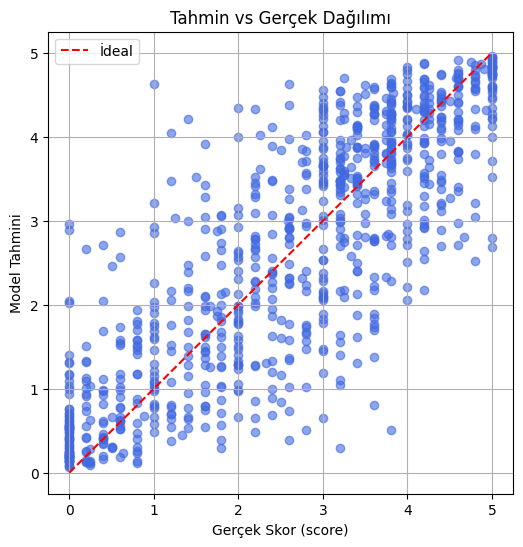

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(labels, preds, alpha=0.6, color='royalblue')
plt.plot([0,5], [0,5], '--', color='red', label='İdeal')
plt.xlabel("Gerçek Skor (score)")
plt.ylabel("Model Tahmini")
plt.title("Tahmin vs Gerçek Dağılımı")
plt.legend()
plt.grid(True)
plt.show()


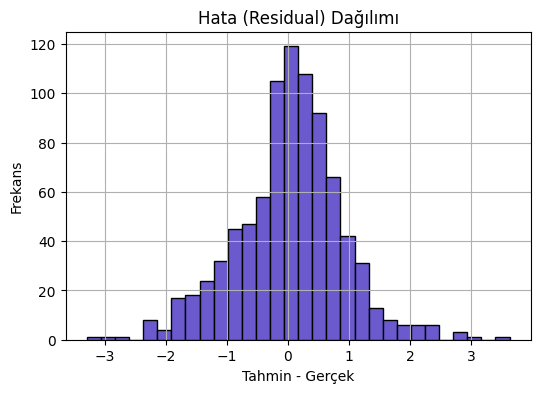

In [ ]:
residuals = preds - labels
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30, color='slateblue', edgecolor='black')
plt.title("Hata (Residual) Dağılımı")
plt.xlabel("Tahmin - Gerçek")
plt.ylabel("Frekans")
plt.grid(True)
plt.show()


In [ ]:
bins = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5)]
for low, high in bins:
    idx = (labels >= low) & (labels < high)
    if np.sum(idx) > 0:
        mae_bin = np.mean(np.abs(preds[idx] - labels[idx]))
        print(f"[{low}, {high}) arası MAE: {mae_bin:.3f} | Örnek sayısı: {np.sum(idx)}")


[0, 1) arası MAE: 0.558 | Örnek sayısı: 166
[1, 2) arası MAE: 0.738 | Örnek sayısı: 117
[2, 3) arası MAE: 0.792 | Örnek sayısı: 139
[3, 4) arası MAE: 0.707 | Örnek sayısı: 241
[4, 5) arası MAE: 0.546 | Örnek sayısı: 160


In [ ]:
import pandas as pd

df_result = pd.DataFrame({
    "sentence1": test_dataset["sentence1"],
    "sentence2": test_dataset["sentence2"],
    "true_score": labels,
    "pred_score": preds,
    "abs_error": np.abs(preds - labels)
})

# En yüksek hatalı 10 örnek
df_worst = df_result.sort_values("abs_error", ascending=False).head(10)
df_worst

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,sentence1,sentence2,true_score,pred_score,abs_error
280,'Umursayan' bir başkan istemiyorum.,Karasmatik bir başkan istemiyorum.,1.0,4.632812,3.632812
714,İki kişi küçük bir tekneyle denize açılıyor.,Yelkenlide iki kadın.,3.8,0.503906,3.296094
440,Sakinler Teksas patlama bölgesine geri döndü,Sakinler Felluce'ye dönüyor,0.0,2.957031,2.957031
567,"Bu googling günlerinde, bir alıntının kaynağın...",Kate Sherwood'a katılıyorum.,3.2,0.295654,2.904346
584,"Hayır, reytinglerinizi etkilemez.","Hayır, değil.",0.0,2.892578,2.892578
321,Din özgürlüğü diye bir şey yoktur.,İfade özgürlüğü diye bir şey yok.,1.2,4.042969,2.842969
858,Suriyeli savaş pilotu Ürdün'e iltica etti,Suriye Başbakanı Ürdün'e iltica etti,1.4,4.207031,2.807031
310,Martı suyun üzerinde yüzüyor.,Suda yüzen küçük bir kuş.,3.6,0.803711,2.796289
731,evinin içinde arka planda vazolu bir kız,Gözlüklü diğer kız el boyası üzerinde çalışırk...,0.2,2.662109,2.462109
607,Bu da seni onların ölümünden kısmen sorumlu ya...,"Bu seni bir çeşit aksesuar yapar, sanırım.",3.0,0.648926,2.351074


deneme